# Proyecto análisis serie de tiempo:

## Pasajeros en la principales rutas aéreas de Colombia 

### Integrantes
    Oscar Mauricio Cepeda Valero
    Carlos Andres Paez Rojas
    Daniel Camilo Rojas Arcila
    
### Descripción de la base de datos

La selección de la base de datos realizada es tomada de la Aeronáutica Civil de  Colombia, y contiene los pasajeros transportados y las sillas voladas por ruta, por aerolínea,  por mes y por año desde Enero 2012 hasta Diciembre 2019. El enfoque será en las 7 ruta más importantes del mercado doméstico, con el fin de realizar el análisis de series de tiempo a cada uan de estas. 

### Contexto del problema y relavancia del análisis
Las razones para seleccionar esta base de datos, es la importancia que tiene el porder determinar el comportamiento de pasajeros y de sillas a ofertar a futuro con el fin de realizar planeación de frecuencias para el caso de una aerolíena. En estos datos se observa que tienen tienen un comportamiento estacional por mes, una tendencia, y una evolución en el tiempo. Lo cual es interesante para el desarrollo de un modelo de series de tiempo que permita proyectar el comportamiento por mes de un año futuro, para fines de planeación. 

Las rutas seleccionadas se describen acontinuación. En la BD están con la nomenclatura de 3 letras y en oden alfabético:
El aeropuerto origen y destino se denotan por tres letras, y la ruta que representa la ida y regreso se denota como la  concatenación de esas letras en orden alfabético.Por ejemplo si origen es Bogotá, destino Cartagena, se representan BOG-CTG, y CTG-BOG, esta es la ida y el regreso, pero la ruta que representa los dos se denota BOG-CTG, ya que en orden alfabetico BOG es primero que CTG. Esto es una agurpación util para ver los pasajeros en la ruta sin disitinguir si ese de ida o regreso y visceversas. Así abordaremos los datos en este trabajo. 

A continuación se ilustra la descripción de las ciudades en una tabla

In [128]:
import pandas as pd

Cuadro = {'Siglas Ruta (ida y regreso)':  ['BOG-MDE', 'BOG-CLO','BOG-CTG','BAQ-BOG','BOG-SMR','ADZ-BOG','BGA-BOG'],
        'Origen/Destino': ['Bogotá', 'Bogotá','Bogotá','Bogotá','Bogotá','Bogotá','Bogotá'],
        'Origen/Destino2': ['Medellín', 'Cali','Cartagena','Barranquilla','Santa Marta','San Andrés','Bucaramanga']
        }
pd.DataFrame(Cuadro)

,Siglas Ruta (ida y regreso),Origen/Destino,Origen/Destino2
0,BOG-MDE,Bogotá,Medellín
1,BOG-CLO,Bogotá,Cali
2,BOG-CTG,Bogotá,Cartagena
3,BAQ-BOG,Bogotá,Barranquilla
4,BOG-SMR,Bogotá,Santa Marta
5,ADZ-BOG,Bogotá,San Andrés
6,BGA-BOG,Bogotá,Bucaramanga


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

## Lectura de la base de datos y Descripción de los Campos
A continuación se lee la base de datos, la cual tiene varios campos, sigla empresa es el código por el cual se prepresenta el operador, en un uestro enfoque nos concentraremos en las compañías que operan las rutas de foco. Cómo se describe a continuación.

#### Descripción de los campos
- SiglaEmpresa: VVC: Viva Airlines / AVA: Avianca / LAN: LATAM Colombia / RPB: Aerorepublica (Wingo)
- Fecha: Fecha que representa el mes, esta BD no está publicada por día si no por mes, es decir siempre el primero de cada mes
- Origen: Código que representa el origen, sin embargo esta la removeremos, ya removimso el origen. 
- Ruta: La ruta que representa pasajeros entre origen y destino ida y vuelta, esta la tomaremos para el trabajo, para esto tendremos que sumar por ruta para capturar los pasajerosde  ida y regreso y pro mes antes de poder unsar la base de datos.

In [2]:
df = pd.read_csv('../EjerciciosModelosAvanzados1/BaseTransporte 1.csv', sep=';')
df.head(10)

,SiglaEmpresa,Fecha,Origen,NumerodeVuelos,HorasBloque,Sillas,CargaOfrecidaKg,PasajerosABordo,Distancia,Ruta,Millas,Ano,Mes
0,VVC,1/03/2020,BOG,54,"117,19",10072,7074,0,NaN,ADZ-BOG,749,2020,mar
1,RPB,1/03/2020,BOG,12,"28,15",2232,1527,0,NaN,ADZ-BOG,749,2020,mar
2,KRE,1/03/2020,BOG,4,"7,65",0,0,0,NaN,ADZ-BOG,749,2020,mar
3,AVA,1/03/2020,BOG,49,"107,77",9419,6587,0,NaN,ADZ-BOG,749,2020,mar
4,AVA,1/03/2020,BOG,33,"72,56",4949,2090,0,NaN,ADZ-BOG,749,2020,mar
5,ARE,1/03/2020,BOG,38,"78,84",6552,3981,0,NaN,ADZ-BOG,749,2020,mar
6,ARE,1/03/2020,BOG,48,"100,54",6828,4450,0,NaN,ADZ-BOG,749,2020,mar
7,VVC,1/02/2020,BOG,76,"169,57",14176,0,12965,NaN,ADZ-BOG,749,2020,feb
8,RPB,1/02/2020,BOG,16,"39,35",2924,124600,2427,NaN,ADZ-BOG,749,2020,feb
9,KRE,1/02/2020,BOG,5,"11,52",0,120000,0,NaN,ADZ-BOG,749,2020,feb


### Limpieza y transformación de los datos

In [133]:
# Observando el tipo de dato que se tiene
#df.dtypes

Filtrando las aerolíneas de enfocque y que operan las rutas seleccionadas de análisis
Se realiza también un filtro excluyendo el 2020, ya que por causa del coronavirus, el tráfico decreció fuertemente, y aún no hay suficientes datos del año para determinar cómo se va a recuperar. Por lo tanto nos efocaremos en el análisis bajo condiciones normales, que es últil para la planeación de capacidad a futuro. Por supuesto una vez se cuente con mas data estos análisis pueden ser  aplicados con la inclusión de 2020 para los años futuros. 
Sin embargo, aún ni siquiera se está operando, por lo cual no se sabe cual será la reacción del mercado. 

In [3]:
# filtro de empresas e información anual completa
df1 = df.loc[((df.SiglaEmpresa == "VVC") | (df.SiglaEmpresa == "ARE")  | (df.SiglaEmpresa == "AVA")) & (df.Ano < 2020)]
df1.dtypes

SiglaEmpresa       object
Fecha              object
Origen             object
NumerodeVuelos      int64
HorasBloque        object
Sillas              int64
CargaOfrecidaKg     int64
PasajerosABordo     int64
Distancia          object
Ruta               object
Millas              int64
Ano                 int64
Mes                object
dtype: object

In [4]:
df1.head()

,SiglaEmpresa,Fecha,Origen,NumerodeVuelos,HorasBloque,Sillas,CargaOfrecidaKg,PasajerosABordo,Distancia,Ruta,Millas,Ano,Mes
25,VVC,1/12/2019,BOG,80,"179,38",14960,0,13972,NaN,ADZ-BOG,749,2019,dic
29,AVA,1/12/2019,BOG,61,"135,6",11556,126484,10591,NaN,ADZ-BOG,749,2019,dic
30,AVA,1/12/2019,BOG,61,"134,5",9193,202620,8462,NaN,ADZ-BOG,749,2019,dic
31,ARE,1/12/2019,BOG,92,"196,47",16008,1595361,13697,NaN,ADZ-BOG,749,2019,dic
32,ARE,1/12/2019,BOG,34,"74,18",4896,493792,4217,NaN,ADZ-BOG,749,2019,dic


In [5]:
df1= df1.groupby(('Fecha', 'SiglaEmpresa', 'Ruta') ,as_index=False).agg({"PasajerosABordo": "sum"})
#df1.columns
df1.head()

C:\Users\oscar\Anacondas3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


,Fecha,SiglaEmpresa,Ruta,PasajerosABordo
0,1/01/2012,ARE,ADZ-BOG,8244
1,1/01/2012,ARE,BAQ-BOG,24984
2,1/01/2012,ARE,BGA-BOG,16453
3,1/01/2012,ARE,BOG-CLO,30221
4,1/01/2012,ARE,BOG-CTG,49541


### Graficando los pasajeros totales por ruta a lo lardo de estos 8 últimos años


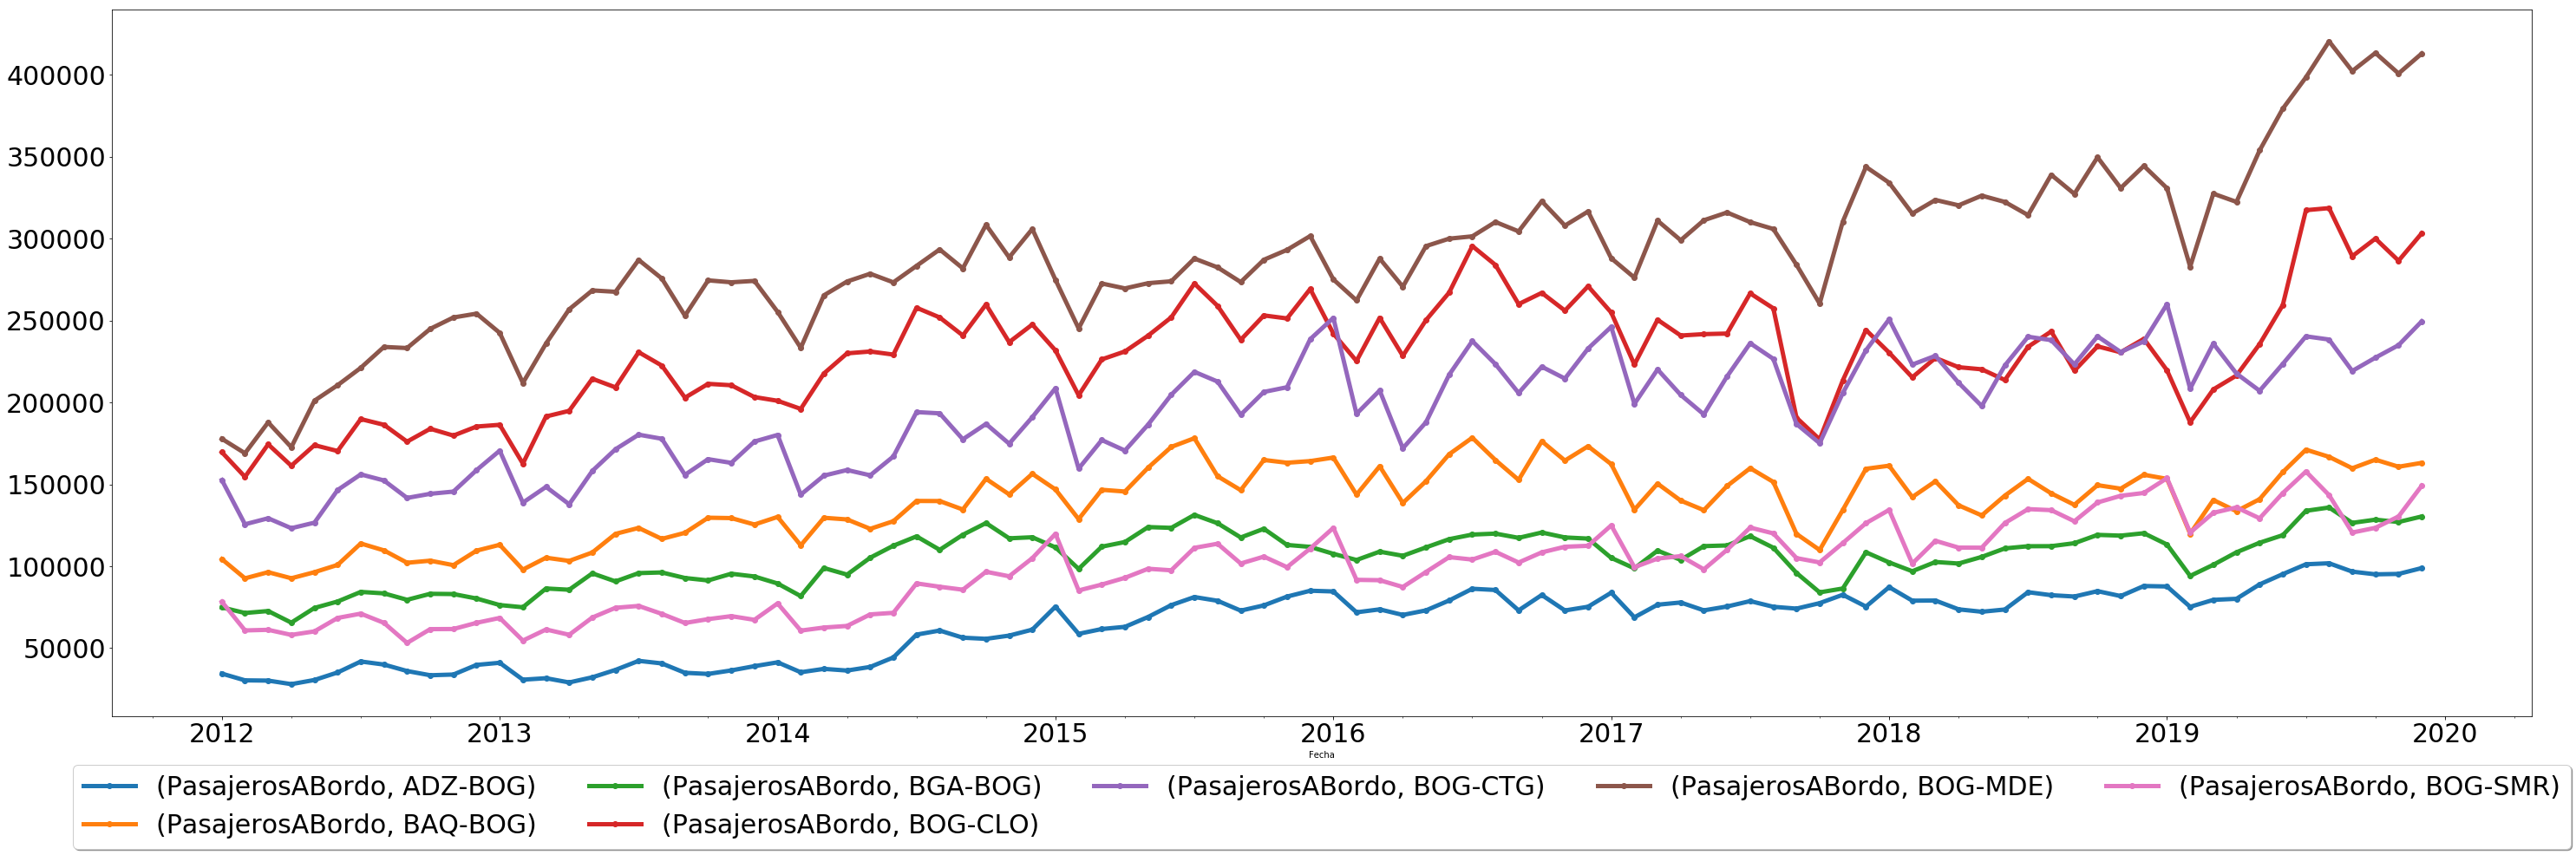

In [6]:
# Realizando agregación y quitando las aerolíneas para ver el comportamiento de la ruta total completa

# Cambiando al fechaa tipo fecha y especificando que el día viene primero
df1.Fecha = pd.to_datetime(df1.Fecha, dayfirst=True)

# Agrupando para hacer la gráfica sin Aierolínea, por  ruta total y sumando por ruta
df2 = df1[['Ruta','Fecha','PasajerosABordo']].groupby(['Fecha', "Ruta"]).sum()
df2=df2.sort_values(by=['Fecha'])

# Unstack es cuadrnado tipo  pivot para gráficar
df3=df2.unstack()
df3=df3.sort_values(by=['Fecha'])

# Realizando el plot
df3.plot(figsize=(50,15), linewidth=5, fontsize=30, style='o-')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5, fontsize=30)


### Análisis de los datos por ruta
ya que el enfoque es analizar cds rutas en particular que parecen ser representativas, BOGCTG, y BOGMDE, una con una estacionalidad más clara (BOG-CTG) que BOG MDE, estás dos se analizarán por separadp, vamos a filtrar y separar los datos de cada rota para poder gráficarlo y entender su comportamiento de cada ruta

In [138]:
#BOGCTG=df1.loc[(df1.Ruta == "ADZ-BOG") & (df.Ano < 2020)]
#BOGMDE=df1.loc[(df1.Ruta == "BOG-CTG") & (df.Ano < 2020)]

# Después de esto toca hacer el aggegate

In [139]:
#ADZBOG = pd.DataFrame(df1[["Fecha", "SiglaEmpresa", "PasajerosABordo" ]].groupby(["Fecha",  "SiglaEmpresa"]).sum())


In [140]:
#ADZBOG=df1.groupby(["Fecha",  "SiglaEmpresa"]).sum()
#ADZBOG.columns

In [141]:
#df1

In [142]:
#ADZBOG=df1.groupby(('Fecha' , 'SiglaEmpresa') ,as_index=False).agg({"PasajerosABordo": "sum"})
#ADZBOG.columns

In [143]:
#ADZBOG.columns

#ADZBOG.loc[ADZBOG.SiglaEmpresa == "VVC"]

# Análisis de la tendencía de los datos

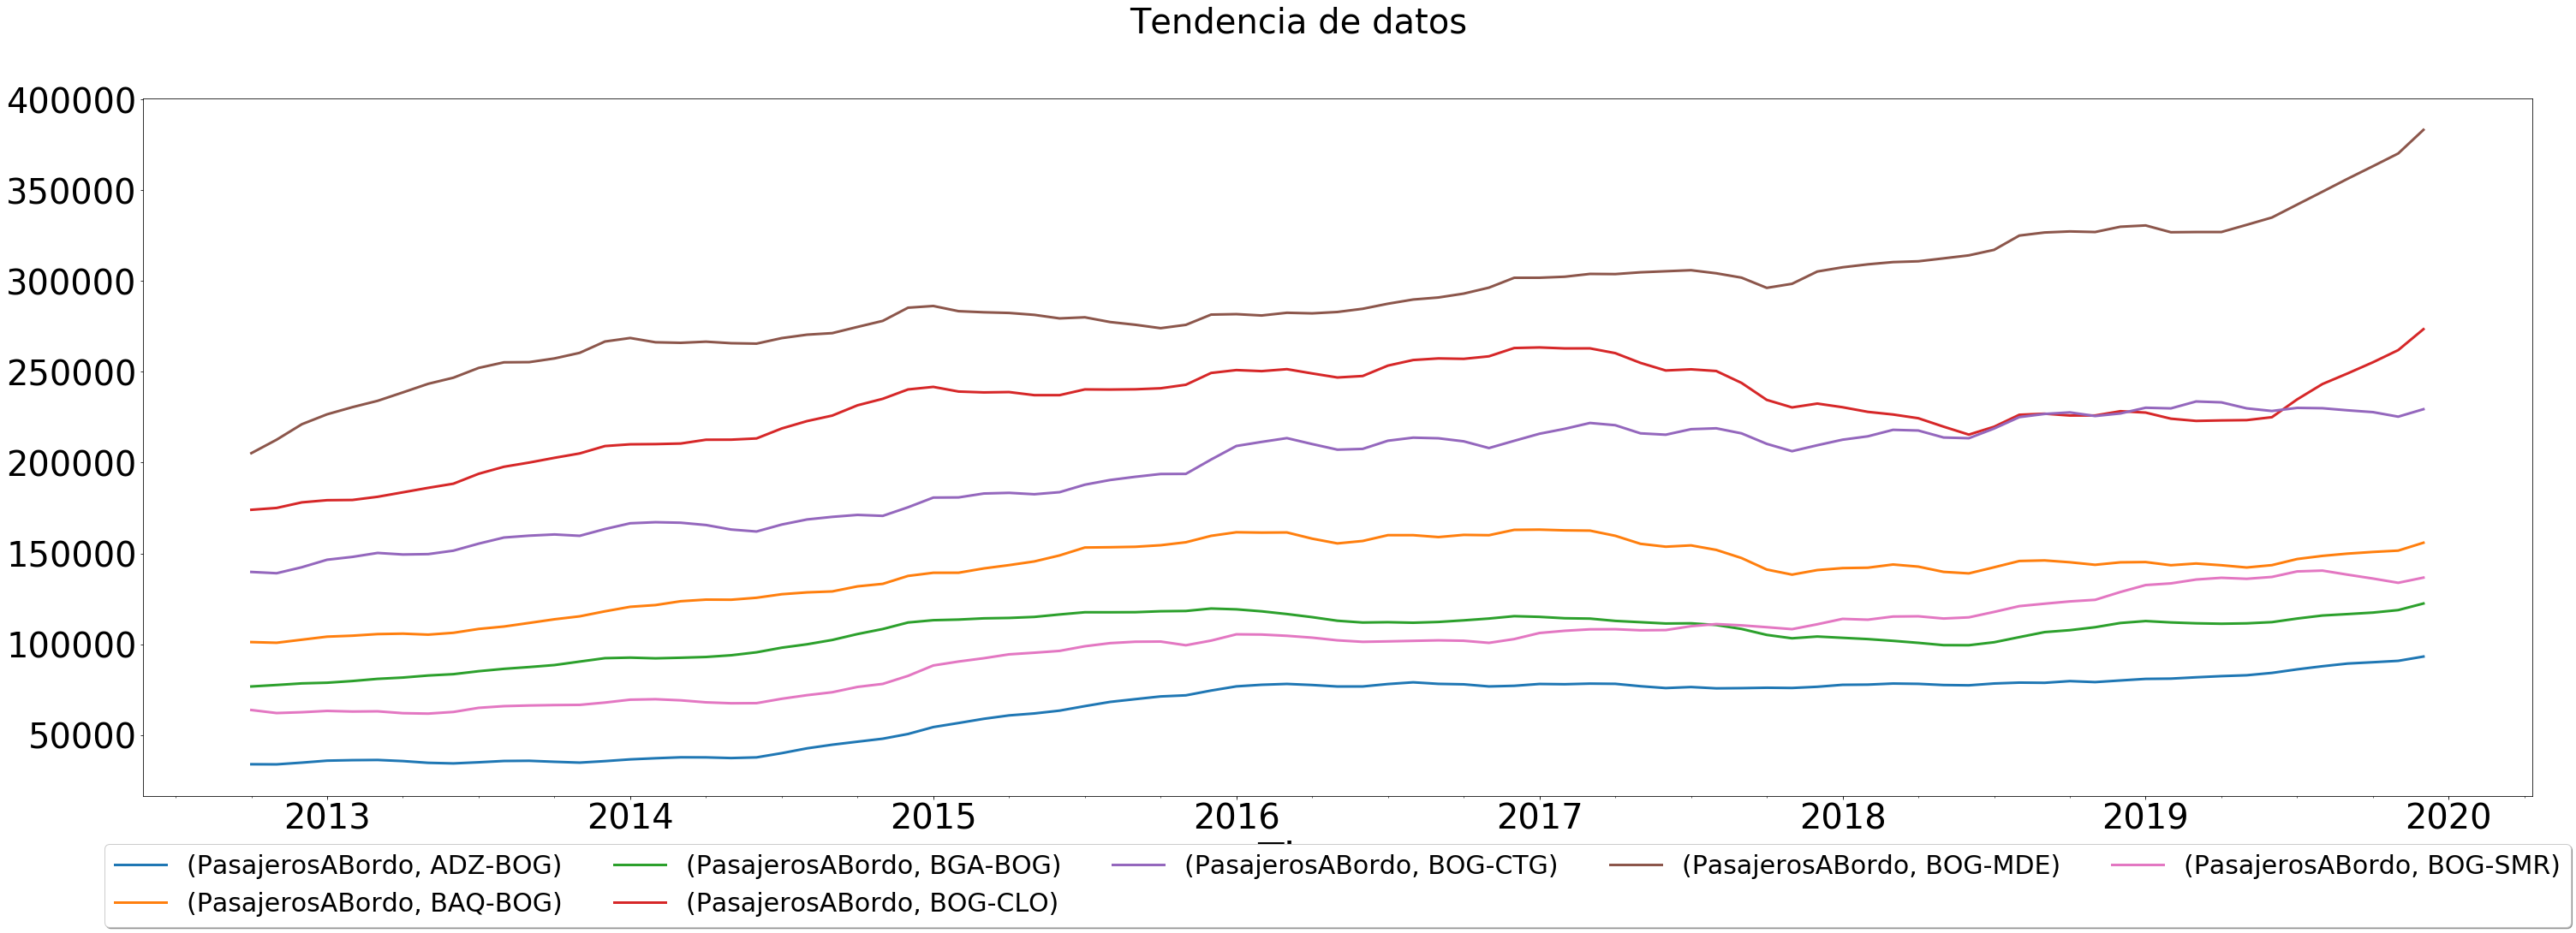

In [7]:
# Anaisis de tendencia
df3.rolling(10).mean().plot(figsize=(50,15), linewidth=3, fontsize=40)
plt.xlabel('Tiempo', fontsize=50)
plt.suptitle('Tendencia de datos', fontsize=40)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5, fontsize=30)

# Análisis de estacionalidad

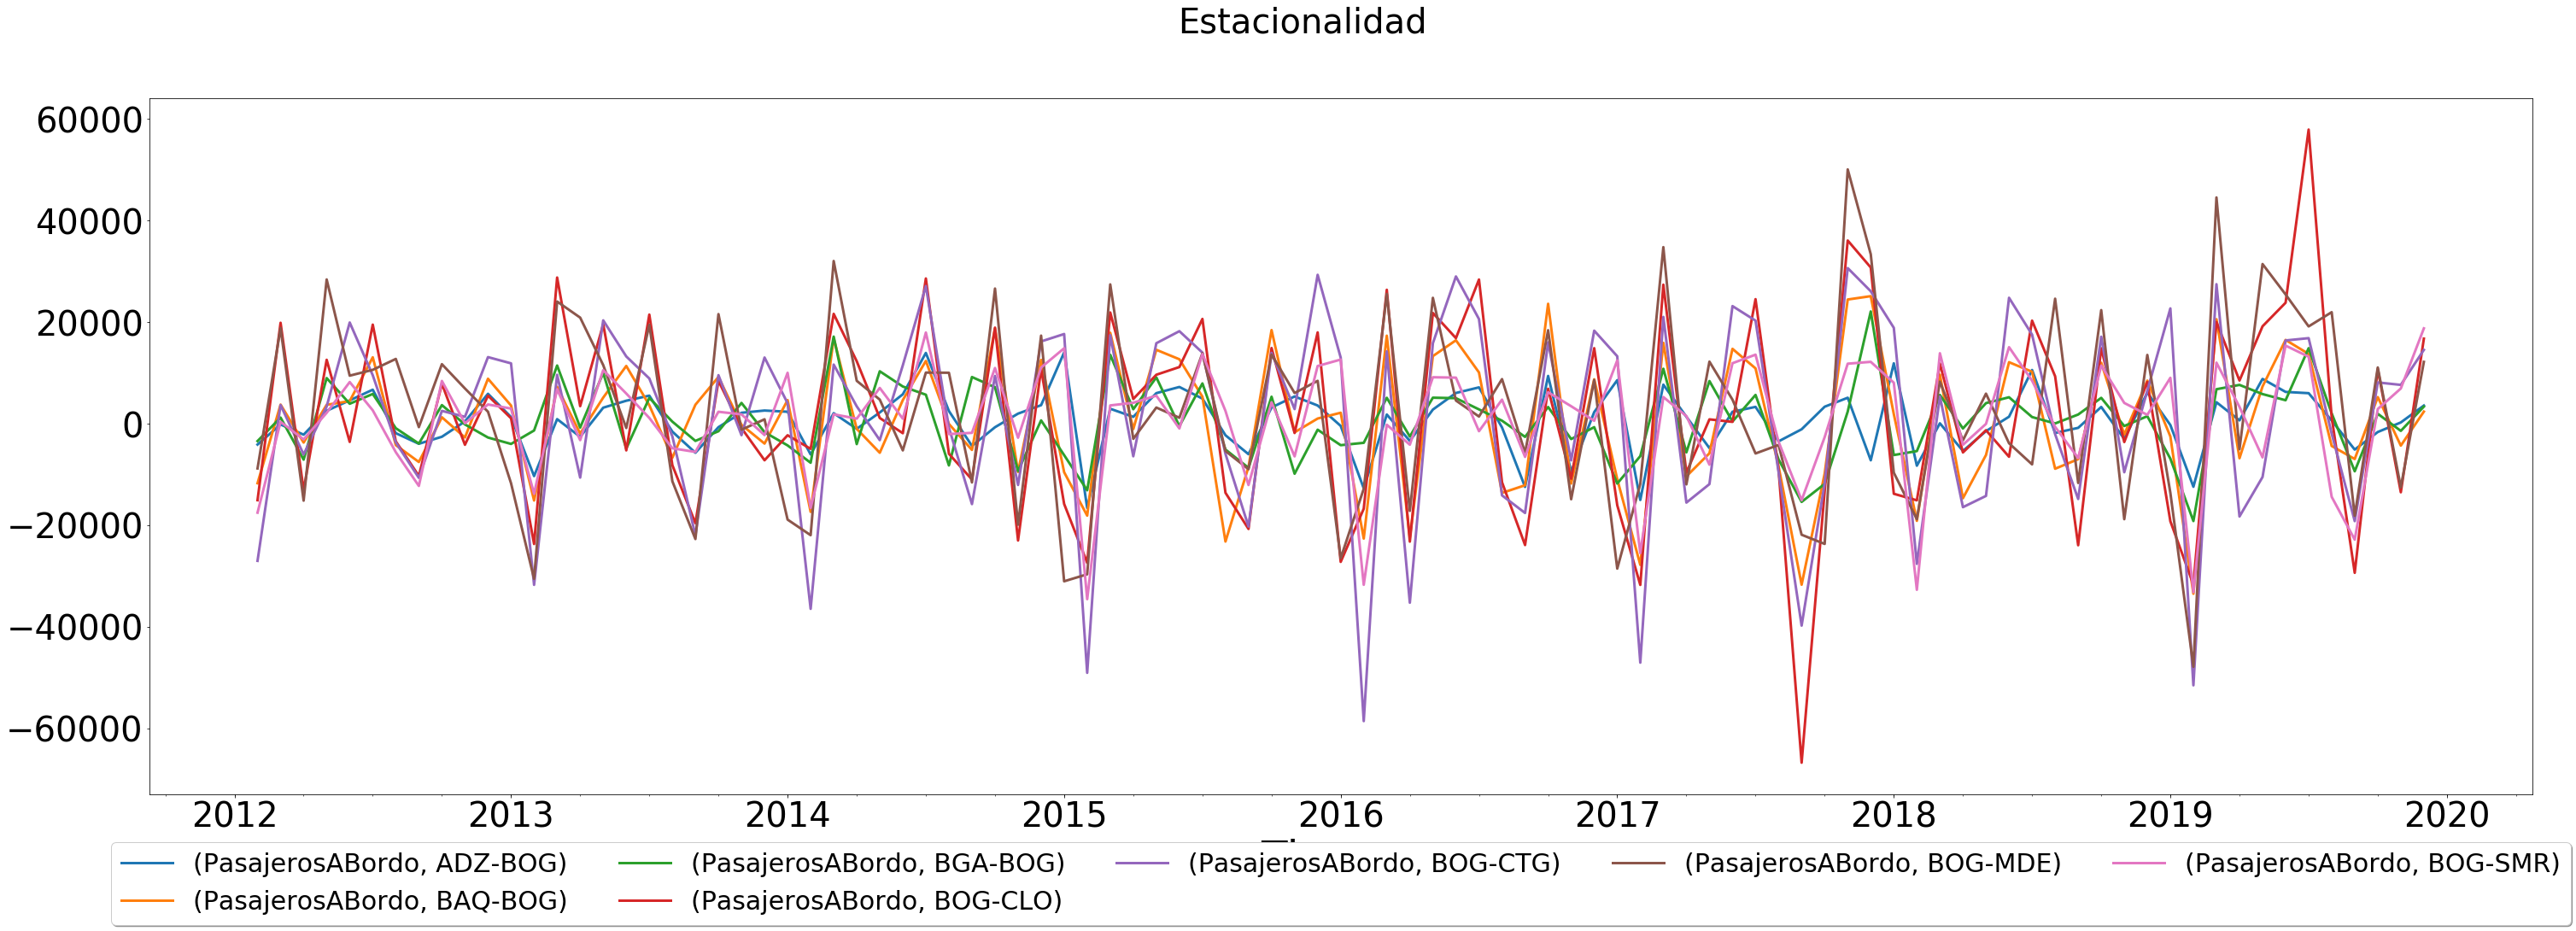

In [8]:
# Analisis estacionalidad
df3.diff().plot(figsize=(50,15), linewidth=3, fontsize=40)
plt.xlabel('Tiempo', fontsize=50)
plt.suptitle('Estacionalidad', fontsize=40)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5, fontsize=30)

# Prueba de estacionariedad

In [13]:
# quitar un nivel para poder operar mejor
df3.columns = df3.columns.droplevel()
df3.head()

Ruta,ADZ-BOG,BAQ-BOG,BGA-BOG,BOG-CLO,BOG-CTG,BOG-MDE,BOG-SMR
Fecha,,,,,,,
2012-01-01,34438,104347,74878,169646,152644,177817,78344
2012-02-01,30327,92612,71450,154571,125621,168996,60812
2012-03-01,30174,96373,72650,174448,129291,187842,61178
2012-04-01,28006,92652,65557,161353,123223,172677,58079
2012-05-01,30549,96370,74542,173935,126612,201087,60224


In [27]:
# Prueba de estacionariedad en cada una de las series
for col in df3:
    print('resultado de prueba estacionariedad en ruta: ', col)
    result = adfuller(df3[col])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

resultado de prueba estacionariedad en ruta:  ADZ-BOG
ADF Statistic: -0.732994
p-value: 0.838017
Critical Values:
	1%: -3.512
	5%: -2.897
	10%: -2.586
resultado de prueba estacionariedad en ruta:  BAQ-BOG
ADF Statistic: -1.849874
p-value: 0.355997
Critical Values:
	1%: -3.512
	5%: -2.897
	10%: -2.586
resultado de prueba estacionariedad en ruta:  BGA-BOG
ADF Statistic: -1.935064
p-value: 0.315750
Critical Values:
	1%: -3.512
	5%: -2.897
	10%: -2.586
resultado de prueba estacionariedad en ruta:  BOG-CLO
ADF Statistic: -1.514356
p-value: 0.526398
Critical Values:
	1%: -3.512
	5%: -2.897
	10%: -2.586
resultado de prueba estacionariedad en ruta:  BOG-CTG
ADF Statistic: -1.486091
p-value: 0.540380
Critical Values:
	1%: -3.512
	5%: -2.897
	10%: -2.586
resultado de prueba estacionariedad en ruta:  BOG-MDE
ADF Statistic: 1.057449
p-value: 0.994837
Critical Values:
	1%: -3.512
	5%: -2.897
	10%: -2.586
resultado de prueba estacionariedad en ruta:  BOG-SMR
ADF Statistic: -0.932090
p-value: 0.77722

In [28]:
# estacionariedad eliminando la tendencía
for col in df3:
    print('resultado de prueba estacionariedad sin tendencia en ruta: ', col)
    result = adfuller(df3[col].diff().iloc[1:])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

resultado de prueba estacionariedad sin tendencia en ruta:  ADZ-BOG
ADF Statistic: -1.894067
p-value: 0.334857
Critical Values:
	1%: -3.512
	5%: -2.897
	10%: -2.586
resultado de prueba estacionariedad sin tendencia en ruta:  BAQ-BOG
ADF Statistic: -2.268276
p-value: 0.182404
Critical Values:
	1%: -3.512
	5%: -2.897
	10%: -2.586
resultado de prueba estacionariedad sin tendencia en ruta:  BGA-BOG
ADF Statistic: -2.431195
p-value: 0.133125
Critical Values:
	1%: -3.512
	5%: -2.897
	10%: -2.586
resultado de prueba estacionariedad sin tendencia en ruta:  BOG-CLO
ADF Statistic: -2.063272
p-value: 0.259537
Critical Values:
	1%: -3.513
	5%: -2.897
	10%: -2.586
resultado de prueba estacionariedad sin tendencia en ruta:  BOG-CTG
ADF Statistic: -3.614052
p-value: 0.005498
Critical Values:
	1%: -3.512
	5%: -2.897
	10%: -2.586
resultado de prueba estacionariedad sin tendencia en ruta:  BOG-MDE
ADF Statistic: -2.477970
p-value: 0.120927
Critical Values:
	1%: -3.512
	5%: -2.897
	10%: -2.586
resultado 

# Graficas de autocorrelación

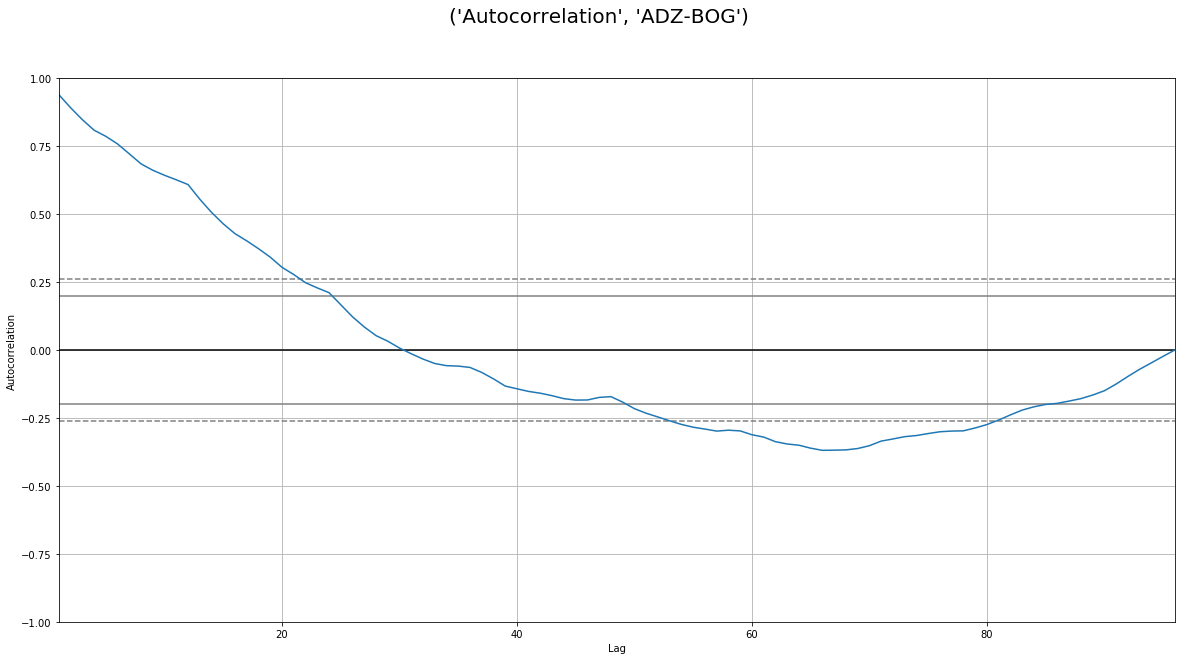

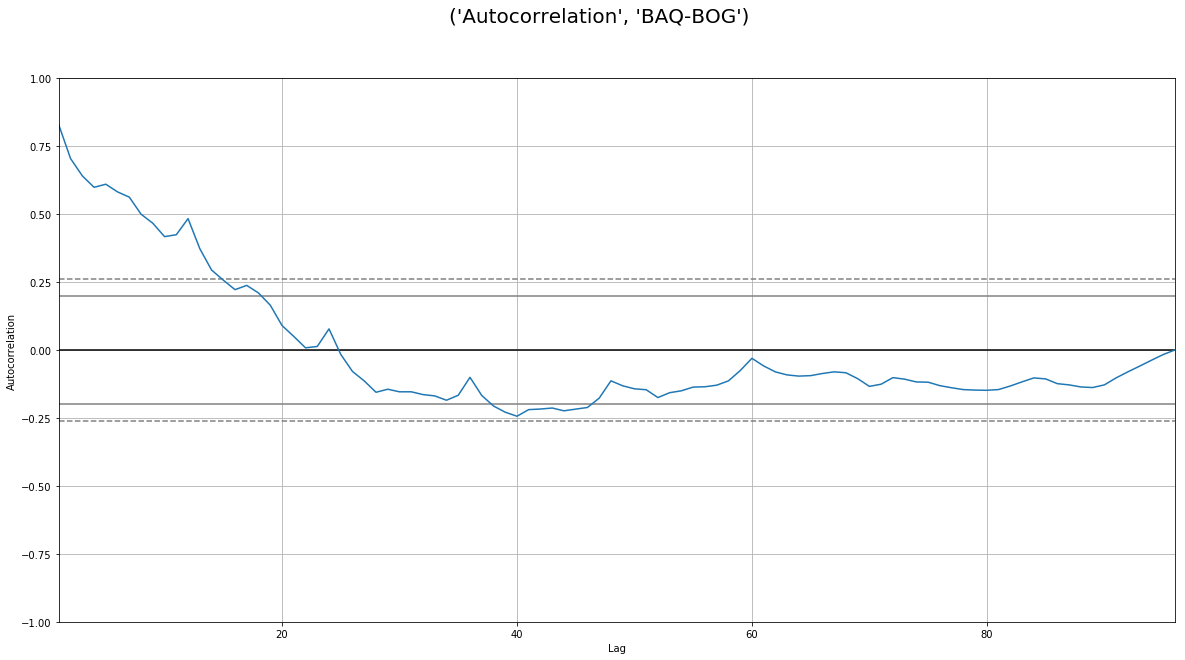

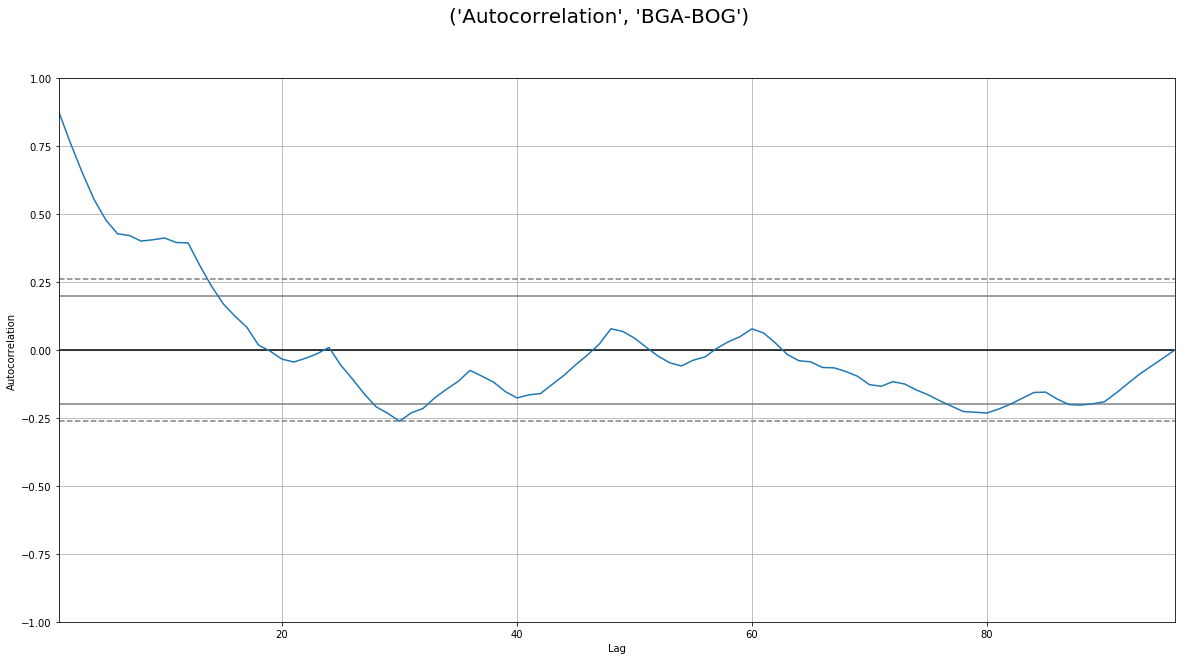

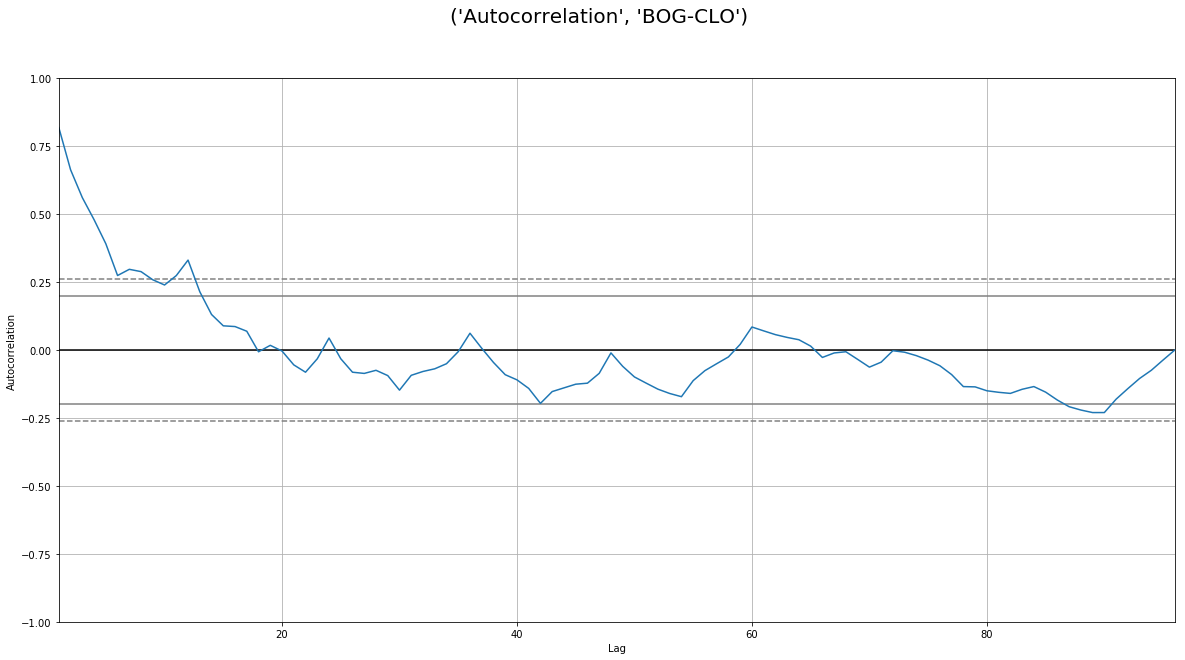

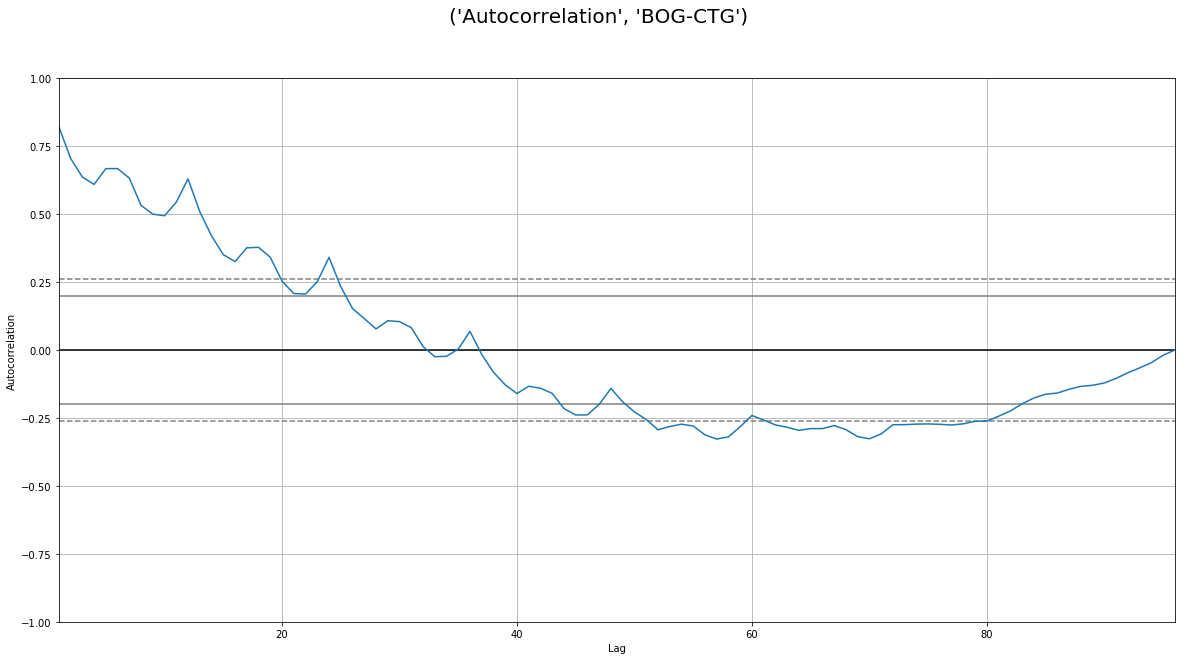

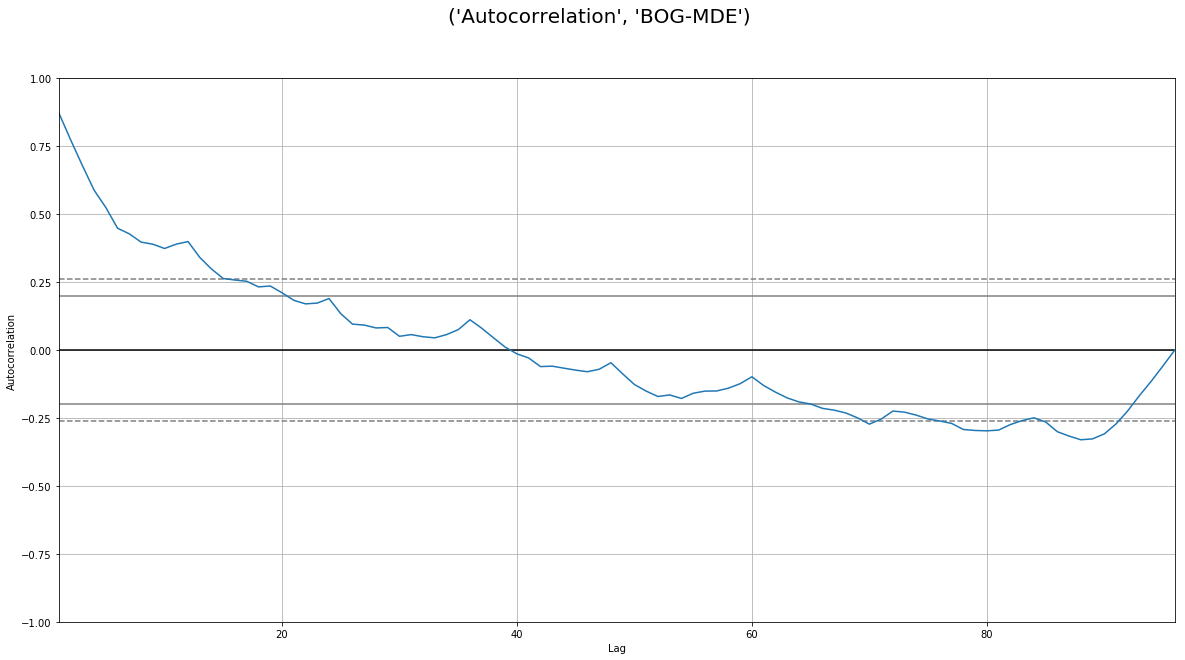

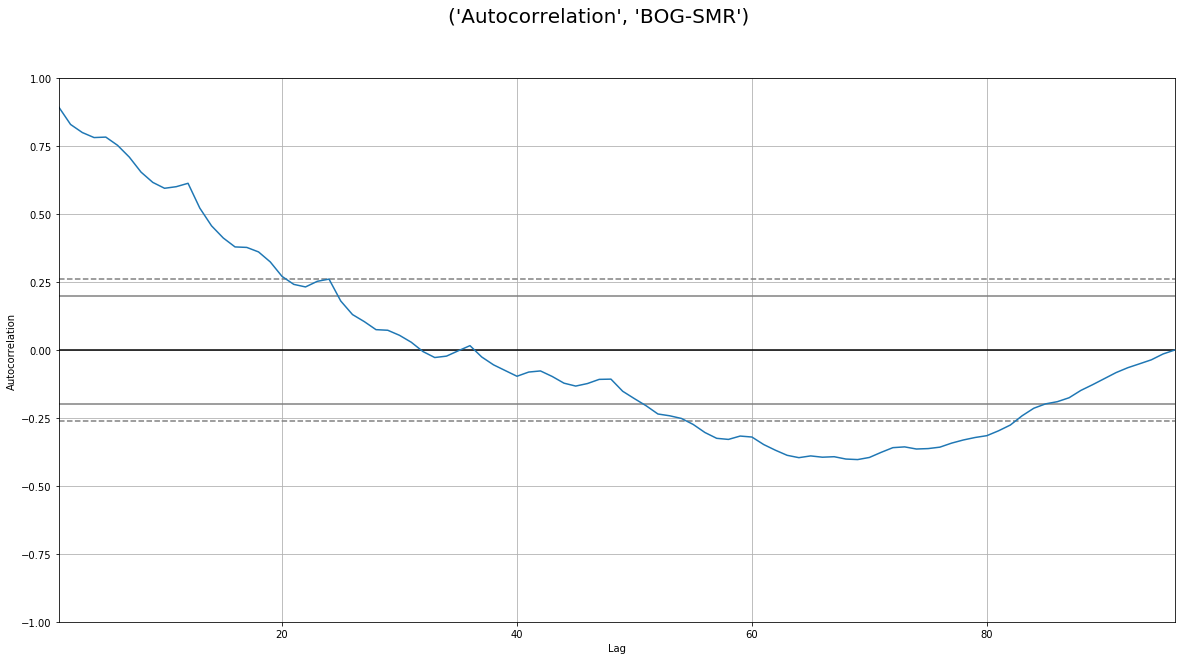

In [34]:
for col in df3:
    plt.figure(figsize=(20,10), linewidth=5)
    pd.plotting.autocorrelation_plot(df3[col])
    plt.suptitle(('Autocorrelation', col), fontsize=20);

# Análisis de autocorrelación y auntocorreelación parcial

In [38]:
df3.columns

Index(['ADZ-BOG', 'BAQ-BOG', 'BGA-BOG', 'BOG-CLO', 'BOG-CTG', 'BOG-MDE',
       'BOG-SMR'],
      dtype='object', name='Ruta')

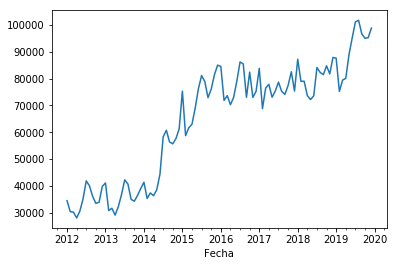

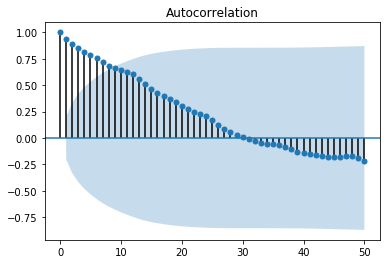

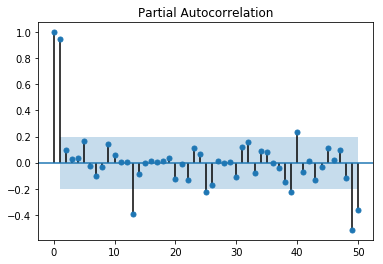

In [40]:
#for col in df3:
df3['ADZ-BOG'].plot()
plot_acf(df3['ADZ-BOG'], lags=50)
plot_pacf(df3['ADZ-BOG'], lags=50);

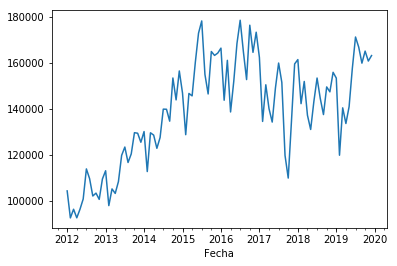

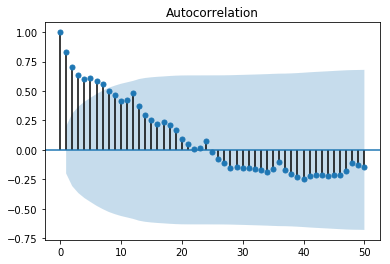

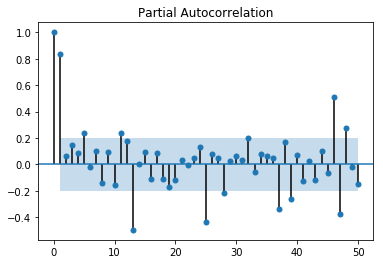

In [41]:
df3['BAQ-BOG'].plot()
plot_acf(df3['BAQ-BOG'], lags=50)
plot_pacf(df3['BAQ-BOG'], lags=50);

C:\Users\oscar\Anacondas3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


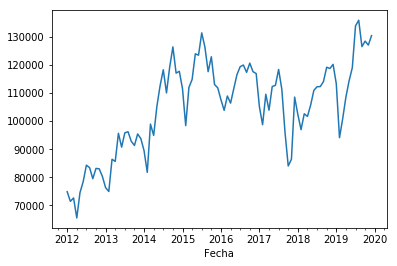

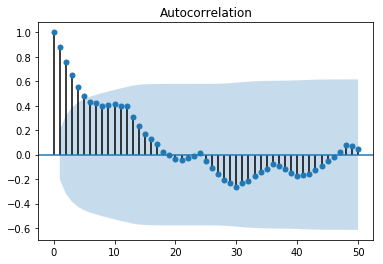

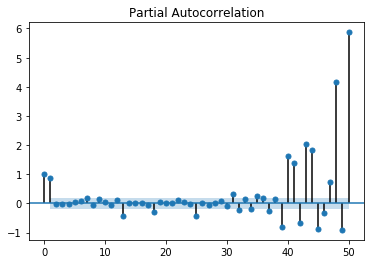

In [42]:
df3['BGA-BOG'].plot()
plot_acf(df3['BGA-BOG'], lags=50)
plot_pacf(df3['BGA-BOG'], lags=50);

C:\Users\oscar\Anacondas3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


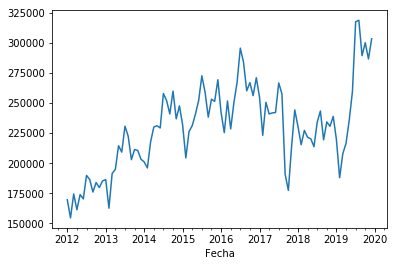

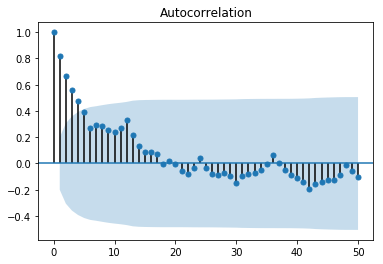

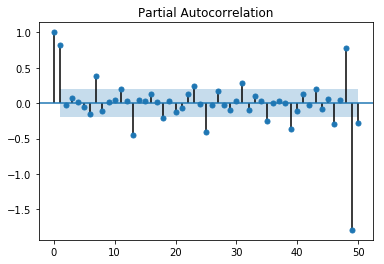

In [43]:
df3['BOG-CLO'].plot()
plot_acf(df3['BOG-CLO'], lags=50)
plot_pacf(df3['BOG-CLO'], lags=50);

C:\Users\oscar\Anacondas3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


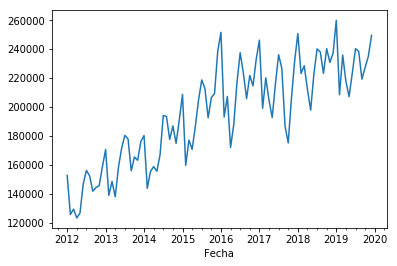

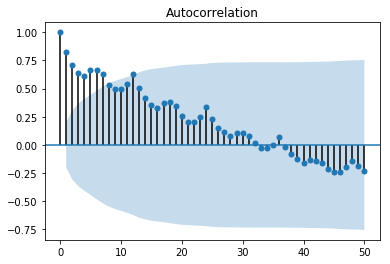

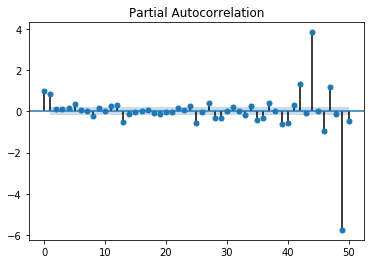

In [44]:
df3['BOG-CTG'].plot()
plot_acf(df3['BOG-CTG'], lags=50)
plot_pacf(df3['BOG-CTG'], lags=50);

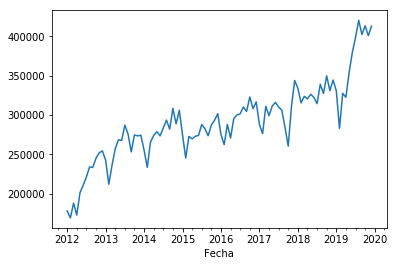

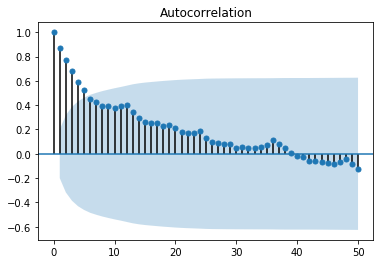

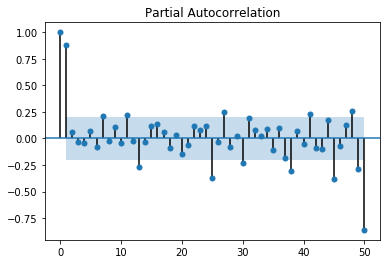

In [45]:
df3['BOG-MDE'].plot()
plot_acf(df3['BOG-MDE'], lags=50)
plot_pacf(df3['BOG-MDE'], lags=50);

C:\Users\oscar\Anacondas3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


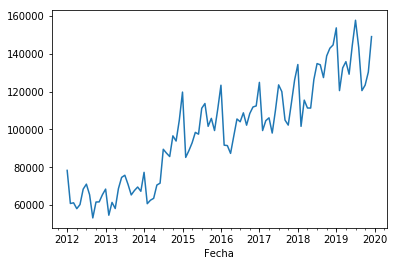

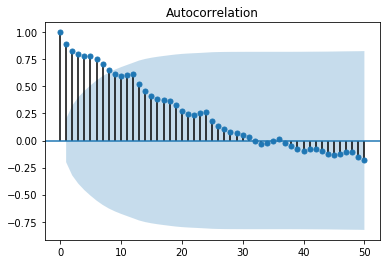

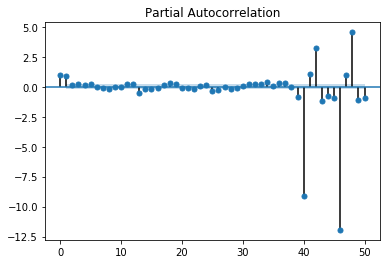

In [46]:
df3['BOG-SMR'].plot()
plot_acf(df3['BOG-SMR'], lags=50)
plot_pacf(df3['BOG-SMR'], lags=50);

# Prueba ajuste ARIMA

In [ ]:

'''
for ma in range(7):
    for ar in range(ma + 1, 8):
        # Predicciones y sobre test
        X = series.values
        size = int(len(X) * 0.66)
        train, test = X[0:size], X[size:len(X)]
        history = [x for x in train]
        predictions = list()
'''
for t in range(len(test)):
    model = ARIMA(history, order=(1, 1, 1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
error = mean_squared_error(test, predictions)     
print('p:', ar, '- d: 1 - q:', ma,'- Test MSE: %.3f' % error) 

In [36]:
Prueba = df1.loc[2,['Fecha']]
Prueba
fecha_dt = datetime.strptime(Prueba, '%d/%m/%Y')
print(fecha_dt)

TypeError: strptime() argument 1 must be str, not Series

In [26]:
from datetime import datetime

#una_fecha = '20/04/2019'


TypeError: strptime() argument 1 must be str, not DataFrame

In [48]:
print('Hola mundo')

Hola mundo
